In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

2023-10-27 19:59:29.939265: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 19:59:30.005760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 19:59:31.173557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Library Versions:
numpy: 1.24.3
pandas: 2.1.1
tensorflow: 2.13.1
tensorflow probability: 0.21.0


In [5]:
from art.attacks.evasion import CarliniL2Method, CarliniLInfMethod

In [9]:
n_epochs = 200
verbose_option = True

# Classification for Ship Detection


Load Ship Detection Dataset

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
LR = 1e-3
BATCH_SIZE=1000

def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'categorical',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


2023-10-27 20:00:25.409098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9
2023-10-27 20:00:25.410791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46497 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1c:00.0, compute capability: 8.9
2023-10-27 20:00:25.411737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46497 MB memory:  -> device: 2, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1d:00.0, compute capability: 8.9
2023-10-27 20:00:25.413134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46497 MB memory:  -> device: 3, name: NV

Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [24]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='softmax')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=False)]
)

In [25]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 1s 12ms/step - loss: 1.8193 - categorical_accuracy: 0.7459 - categorical_crossentropy: 1.8193
Epoch 2/200
4/4 [==============================] - 0s 11ms/step - loss: 0.8639 - categorical_accuracy: 0.6034 - categorical_crossentropy: 0.8639
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.6520 - categorical_accuracy: 0.5934 - categorical_crossentropy: 0.6520
Epoch 4/200
4/4 [==============================] - 0s 12ms/step - loss: 0.6051 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.6051
Epoch 5/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5429 - categorical_accuracy: 0.7934 - categorical_crossentropy: 0.5429
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 0.5080 - categorical_accuracy: 0.7625 - categorical_crossentropy: 0.5080
Epoch 7/200
4/4 [==============================] - 0s 13ms/step - loss: 0.4616 - categorical_accuracy: 0.8159 - categorical_crosse

Evaluate the classification model on the test data

In [26]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 176ms/step - loss: 0.1680 - categorical_accuracy: 0.9438 - categorical_crossentropy: 0.1680


[0.16795217990875244, 0.9437500238418579, 0.16795217990875244]

In [14]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [28]:
model(np.reshape(examples[5],[1,80,80,3])).numpy()[0,0]

0.0034451312

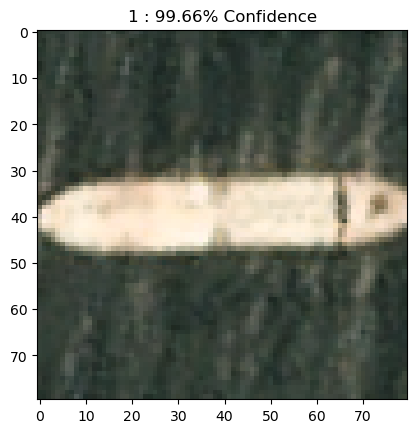

In [29]:
plt.figure()
plt.imshow(examples[5])
confidence = model(np.reshape(examples[5],[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [33]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 1s 15ms/step - loss: 1.5556 - categorical_accuracy: 0.7209 - categorical_crossentropy: 1.5556
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 0.6650 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.6650
Epoch 3/200
4/4 [==============================] - 0s 13ms/step - loss: 0.5840 - categorical_accuracy: 0.7753 - categorical_crossentropy: 0.5840
Epoch 4/200
4/4 [==============================] - 0s 12ms/step - loss: 0.5801 - categorical_accuracy: 0.7678 - categorical_crossentropy: 0.5801
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.4948 - categorical_accuracy: 0.7728 - categorical_crossentropy: 0.4948
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 0.4531 - categorical_accuracy: 0.8116 - categorical_crossentropy: 0.4531
Epoch 7/200
4/4 [==============================] - 0s 12ms/step - loss: 0.4389 - categorical_accuracy: 0.8178 - categorical_crosse

## Carlini-Wagner L2

In [34]:
from art.estimators.classification import TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
)
carlini_l2 = CarliniL2Method(classifier=classifier)
adv_ex = carlini_l2.generate(x=np.reshape(examples[5],[1,80,80,3]))

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

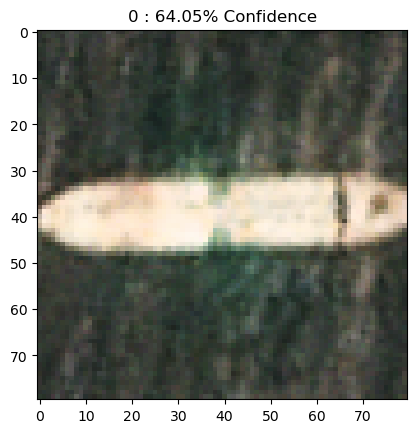

In [36]:
plt.figure()
adv_example = adv_ex 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example,[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

# Carlini-Wagner L-inf

In [38]:
carlini_linf = CarliniLInfMethod(classifier=classifier)
adv_ex = carlini_linf.generate(x=np.reshape(examples[5],[1,80,80,3]))

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

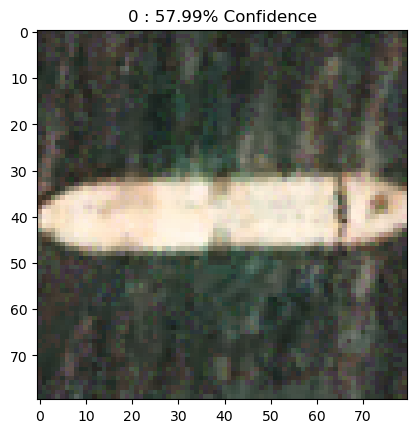

In [39]:
plt.figure()
adv_example = adv_ex 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example,[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

# Deep Fool

In [10]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200


2023-10-27 20:00:51.417958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-27 20:00:51.431297: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f66cc01d2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-27 20:00:51.431338: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-27 20:00:51.431346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-27 20:00:51.431353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-27 20:00:51.431359: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA RTX 6000 Ada Generation,

4/4 [==============================] - 5s 20ms/step - loss: 1.2252 - categorical_accuracy: 0.7075 - categorical_crossentropy: 1.2252
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7644 - categorical_accuracy: 0.7247 - categorical_crossentropy: 0.7644
Epoch 3/200
4/4 [==============================] - 0s 16ms/step - loss: 0.5059 - categorical_accuracy: 0.7794 - categorical_crossentropy: 0.5059
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 0.4410 - categorical_accuracy: 0.8188 - categorical_crossentropy: 0.4410
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 0.3966 - categorical_accuracy: 0.8334 - categorical_crossentropy: 0.3966
Epoch 6/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3932 - categorical_accuracy: 0.8359 - categorical_crossentropy: 0.3932
Epoch 7/200
4/4 [==============================] - 0s 14ms/step - loss: 0.4013 - categorical_accuracy: 0.8322 - categorical_crossentropy: 0.40

In [12]:
from art.estimators.classification import TensorFlowV2Classifier

classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
)

In [15]:
from art.attacks.evasion import DeepFool

deepfool = DeepFool(classifier=classifier, max_iter=100, epsilon=1e-6, nb_grads=2, batch_size=1, verbose=True)
adv_ex = deepfool.generate(x=np.reshape(examples[5],[1,80,80,3]))

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

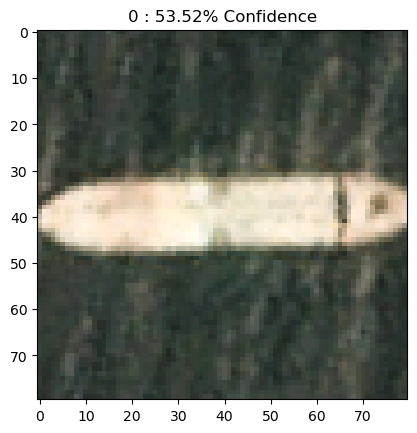

In [16]:
plt.figure()
adv_example = adv_ex 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example,[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()